In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from keras.backend import clear_session
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Softmax

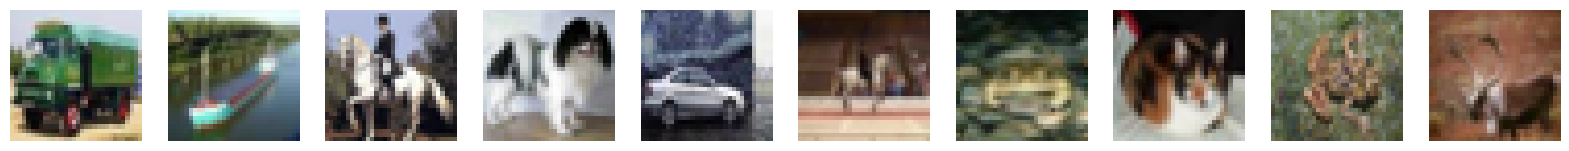

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images by scaling the pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class labels (y_train, y_test) to one-hot encoded format
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Plot a few random images from the training set
def plot_random_images():
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        random_idx = np.random.randint(0, len(x_train))
        axes[i].imshow(x_train[random_idx])
        axes[i].axis('off')
    plt.show()

# Call the function to display random images
plot_random_images()

### Add reusable methods for plotting confusion matrix / comparison of accuracy and loss

In [25]:
def show_confusion_matrix(cnn_model, name):
    predictions = cnn_model.predict(x_test)
    predictions = np.argmax(predictions, axis=1)
    gt = np.argmax(y_test, axis=1)
    
    cm = metrics.confusion_matrix(gt, predictions)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(f"output/confusion_matrix_{name}.png")

In [26]:
def show_compare_graph(cnn_history, name):
    plt.title('Loss / Accuracy')
    plt.plot(cnn_history.history['loss'], color='blue', label='train')
    plt.plot(cnn_history.history['accuracy'], color='green', label='train')
    plt.show()
    plt.savefig(f"output/compare_graph_{name}.png")

### Define first model with 60 epochs and a batch size of 512

In [ ]:
clear_session()

In [ ]:
# Define the CNN model
model = Sequential()

# Add a convolutional layer with a 3x3 filter, 32 filters, and input shape (32, 32, 3)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add a dense layer with 100 units
model.add(Dense(100, activation='relu'))

# Add the output classification layer with softmax activation for 10 classes
model.add(Dense(10, activation='softmax'))

# Print model summary
model.summary()

In [5]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=60, batch_size=512, validation_data=(x_test, y_test))

Epoch 1/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 195ms/step - accuracy: 0.1415 - loss: 2.2806 - val_accuracy: 0.2274 - val_loss: 2.1960
Epoch 2/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - accuracy: 0.2402 - loss: 2.1624 - val_accuracy: 0.2737 - val_loss: 2.0711
Epoch 3/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - accuracy: 0.2889 - loss: 2.0397 - val_accuracy: 0.3172 - val_loss: 1.9686
Epoch 4/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.3230 - loss: 1.9533 - val_accuracy: 0.3275 - val_loss: 1.9169
Epoch 5/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.3348 - loss: 1.9024 - val_accuracy: 0.3204 - val_loss: 1.9239
Epoch 6/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.3524 - loss: 1.8633 - val_accuracy: 0.3548 - val_loss: 1.8353
Epoch 7/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.3651 - loss: 1.8288 - val_accuracy: 0.3775 - val_loss: 1.8012
Epoch 8/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.3790 - loss: 1.7866 - val_accu

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


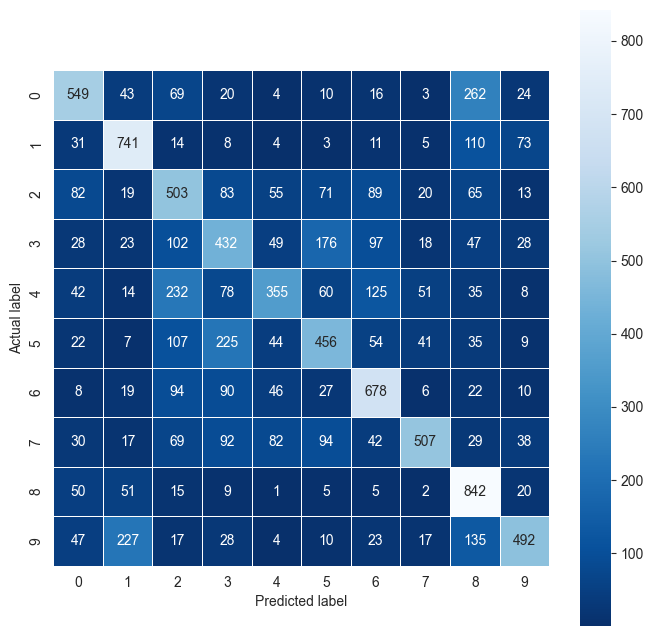

In [27]:
show_confusion_matrix(model, 'model_1')

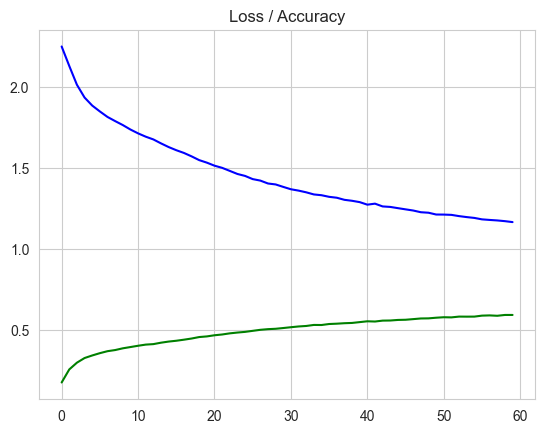

<Figure size 640x480 with 0 Axes>

In [28]:
show_compare_graph(history, 'model_1')

As we can see, the result is not very gut. The loss is higher as the accuracy